In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime
from datetime import date

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset=pd.read_excel(r'DataGH.xlsx')

In [3]:
futureData = pd.read_excel(r'futureData_GH.xlsx')

In [4]:
dataset.dropna(inplace=True)

In [5]:
dataset.shape

(46033, 15)

In [6]:
dataset.columns = ['ds', 'Product Category', 'SKU', 'y', 'Inf count', 'WeekDay',
       'Weekend', 'Launch_Event', 'BOGO_Event', 'Other_Event','Facebook FOLLOWERS COUNT', 'Instagram FOLLOWERS COUNT', 'Twitch FOLLOWERS COUNT', 'Twitter FOLLOWERS COUNT', 'YouTube FOLLOWERS COUNT']

In [47]:
#IF WE WANT TO FORECAST FOR THESE TWO SKU'S
category_data = dataset.loc[[x in ['SKU1','SKU21'] for x in dataset.SKU],:]

In [49]:
n_category_sku = category_data.SKU.nunique()
category_sku = category_data.SKU.unique()

In [50]:
n_category_sku

2

In [51]:
category_data.shape

(367, 15)

In [52]:
data = category_data.groupby(['ds']).sum()[['y']]

In [53]:
data.reset_index(inplace=True)

In [54]:
category_data = data.merge(category_data[['ds', 'Inf count', 'WeekDay',
       'Weekend', 'Launch_Event', 'BOGO_Event', 'Other_Event','Facebook FOLLOWERS COUNT', 'Instagram FOLLOWERS COUNT', 'Twitch FOLLOWERS COUNT', 'Twitter FOLLOWERS COUNT', 'YouTube FOLLOWERS COUNT']], 
           how='inner', on='ds')

In [55]:
data= category_data

### Checking Stationarity

In [56]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(qty):
    result=adfuller(qty)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [57]:
def differencing(data):
    shift_value=[]
    diff = []
    for i in range(1,30):
        dataset = data - data.shift(i)
        test_result = adfuller(dataset.dropna())
        if test_result[1] <= 0.05:
            shift_value.append(i)
            diff.append(test_result[1])
    
    shift_value= pd.DataFrame(shift_value, columns=['Shift'])
    diff= pd.DataFrame(diff, columns = ['Diff'])
    
    Diff_DF = pd.concat([shift_value, diff], axis=1)
    
    return Diff_DF

In [58]:
def create_data_sarimax(data):
    data_1_1 = data.copy()
    # creating test data
    condition = (((data_1_1.index.month==5) | (data_1_1.index.month==6)| (data_1_1.index.month==7))
                    & (data_1_1.index.year==2020))
    test_1_1 = data_1_1.loc[condition]
    train_1_1 = data_1_1.loc[~condition]
    #test_1_1["ds"]=test_1_1.index
    return train_1_1, test_1_1

In [59]:
def create_data_prophet(data):
    # creating test data
    data_1_2 = data.copy()
    condition = (((data_1_2.ds.dt.month==5) | (data_1_2.ds.dt.month==6) | (data_1_2.ds.dt.month==7))
                    & (data_1_2.ds.dt.year==2020))
    test_1_2 = data_1_2.loc[condition]
    train_1_2 = data_1_2.loc[~condition]

    return train_1_2, test_1_2

In [60]:
arma = []
sku_stationarity = []
less_records = []
rec_ten = []

In [61]:
def uni_sarimax(data):
    data_0 = data.copy()
    data_0.set_index('ds', inplace=True)
    train_0, test_0 = create_data_sarimax(data_0)
    df_0 = pd.DataFrame()
    result_0 = np.nan
    if (len(test_0)>4) & (len(train_0)>7):
        # finding optimal p and q
        a = sm.tsa.arma_order_select_ic(train_0['Seasonal First Difference'].dropna(), max_ar=6, max_ma=6, ic='aic', trend='c')
        p= a['aic_min_order'][0]
        q= a['aic_min_order'][1]
        arma.append(a['aic_min_order'])

        model_0 = sm.tsa.statespace.SARIMAX(train_0['y'],
                                          order= (p,1,q) , seasonal_order= (p,1,q,7),
                                      #,mle_regression=True, 
                                          initialization='approximate_diffuse')
        start_params = np.r_[[0] * (model_0.k_params - 1), 1]
        result_0 = model_0.fit(start_params=start_params)
        pred = result_0.forecast(len(test_0))

        pred = pd.DataFrame(pred, columns=['yhat'])
        #pred_ci = pd.DataFrame()
       # pred_ci = result.get_forecast(len(test))
        pred.index= test_0.index
      #  pred_ci.index = test.index
        
        df_0 =pd.concat([test_0, pred], axis=1)
        df_0['model']= 'uni_sarimax'
        
     #   df_0['ds'] = df_0.index
      #  test_0['ds'] = test_0.index
    
    
    return df_0, result_0, test_0, train_0


In [62]:
def multi_sarimax(data):
    data_1 = data.copy()
    data_1.set_index('ds', inplace=True)
    train_1, test_1 = create_data_sarimax(data_1)
    df_1 = pd.DataFrame()
    result_1 = np.nan
    if len(test_1)>4 & (len(train_1)>7):
        # finding optimal p and q
        a = sm.tsa.arma_order_select_ic(train_1['Seasonal First Difference'].dropna(), max_ar=6, max_ma=6, ic='aic', trend='c')
        p= a['aic_min_order'][0]
        q= a['aic_min_order'][1]
        arma.append(a['aic_min_order'])

        model_1 = sm.tsa.statespace.SARIMAX(train_1['y'],
                                              exog=train_1[['Inf count','WeekDay', 'Weekend', 'Launch_Event', 'BOGO_Event','Other_Event','Facebook FOLLOWERS COUNT', 'Instagram FOLLOWERS COUNT', 'Twitch FOLLOWERS COUNT', 'Twitter FOLLOWERS COUNT', 'YouTube FOLLOWERS COUNT']].values,
                                          order= (p,1,q) , seasonal_order= (p,1,q,7),
                                      #,mle_regression=True, 
                                          initialization='approximate_diffuse')
        start_params = np.r_[[0] * (model_1.k_params - 1), 1]
        result_1 = model_1.fit(start_params=start_params)
        pred = result_1.forecast(len(test_1),
                               exog=test_1[['Inf count','WeekDay', 'Weekend', 'Launch_Event', 'BOGO_Event','Other_Event','Facebook FOLLOWERS COUNT', 'Instagram FOLLOWERS COUNT', 'Twitch FOLLOWERS COUNT', 'Twitter FOLLOWERS COUNT', 'YouTube FOLLOWERS COUNT']].values)

        pred = pd.DataFrame(pred, columns=['yhat'])
       # pred_ci = pd.DataFrame()
      #  pred_ci = result.get_forecast(len(test),
     #                                exog=train[['Inf count','WeekDay', 'Weekend', 'Launch_Event', 'BOGO_Event','Other_Event']].values)
        pred.index= test_1.index
       # pred_ci.index = test.index
        df_1 =pd.concat([test_1, pred], axis=1)
        df_1['model']= 'multi_sarimax'
        #df_1.reset_index(inplace=True)
        df_1['ds'] = df_1.index
        #test_1['ds'] = test_1.index

    return df_1, result_1, test_1


In [63]:
def uni_prophet(data):
    data_2 = data.copy()
    data_2.reset_index(inplace=True)
    del data_2['index']
    train_2, test_2 = create_data_prophet(data_2)
    df_2 = pd.DataFrame()
    pro_basic_2 = np.nan
    if len(test_2)>4 & (len(train_2)>7):
        X_test_2 = test_2[['ds']]
        
        pro_basic_2 = Prophet()
        train_2 = train_2[['ds','y']]
        pro_basic_2.fit(train_2)
        
        pred = pro_basic_2.predict(X_test_2)[['ds','yhat']]
        
        df_2 = pred.merge(test_2[['ds','y']], how='inner', on='ds')
        
       
        pred = pd.DataFrame(pred)
       # pred_ci = pd.DataFrame()
      #  pred_ci = result.get_forecast(len(test),
     #                                exog=train[['Inf count','WeekDay', 'Weekend', 'Launch_Event', 'BOGO_Event','Other_Event']].values)
        #pred.index= test.index
       # pred_ci.index = test.index
       
        df_2['model']= 'uni_prophet'
        

    return df_2, pro_basic_2, test_2


In [64]:
def multi_prophet(data):
    data_3 = data.copy()
    data_3.reset_index(inplace=True)
    del data_3['index']
    train_3, test_3 = create_data_prophet(data_3)
    df_3 = pd.DataFrame()
    pro_regressor_3 = np.nan
    if len(test_3)>4 & (len(train_3)>7):
        X_test_3 = test_3[['ds', 'Inf count', 'WeekDay', 'Weekend', 'Launch_Event', 'BOGO_Event', 'Other_Event','Facebook FOLLOWERS COUNT', 'Instagram FOLLOWERS COUNT', 'Twitch FOLLOWERS COUNT', 'Twitter FOLLOWERS COUNT', 'YouTube FOLLOWERS COUNT']]
       
        #Additional Regressor
        pro_regressor_3 = Prophet()
        pro_regressor_3.add_regressor('Inf count')
        pro_regressor_3.add_regressor('WeekDay')
        pro_regressor_3.add_regressor('Weekend')
        pro_regressor_3.add_regressor('Launch_Event')
        pro_regressor_3.add_regressor('BOGO_Event')
        pro_regressor_3.add_regressor('Other_Event')
        pro_regressor_3.add_regressor('Facebook FOLLOWERS COUNT')
        pro_regressor_3.add_regressor('Instagram FOLLOWERS COUNT')
        pro_regressor_3.add_regressor('Twitch FOLLOWERS COUNT')
        pro_regressor_3.add_regressor('Twitter FOLLOWERS COUNT')
        pro_regressor_3.add_regressor('YouTube FOLLOWERS COUNT')
        pro_regressor_3.fit(train_3)

        
        pred = pro_regressor_3.predict(X_test_3)[['ds','yhat']]
        
        df_3 = pred.merge(test_3[['ds','y']], how='inner', on='ds')
        
       
        pred = pd.DataFrame(pred)
       # pred_ci = pd.DataFrame()
      #  pred_ci = result.get_forecast(len(test),
     #                                exog=train[['Inf count','WeekDay', 'Weekend', 'Launch_Event', 'BOGO_Event','Other_Event']].values)
        #pred.index= test.index
       # pred_ci.index = test.index
        
        df_3['model']= 'multi_prophet'

    return df_3, pro_regressor_3, test_3


In [65]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [66]:
def selecting_best_model(df):
    df_0 = df.copy()
    
    #df = df.groupby(['model','SKU', 'Year', 'Month']).sum()[['y', 'yhat']]
    
    return df_0.loc[df_0.mape == df_0.mape.min(),['model']].iloc[0].values[0]
    

In [67]:
algorithm = ['uni_sarimax','multi_sarimax','uni_prophet', 'multi_prophet']
#algorithm.index('multi')

In [68]:
future_days = 120
#model2.make_future_dataframe(future_days, freq = "D", include_history = False)

In [69]:
n_category_sku

2

DickeyFuller test results of 
ADF Test Statistic : -5.44651871889253
p-value : 2.702900809781887e-06
#Lags Used : 14
Number of Observations Used : 345
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
None


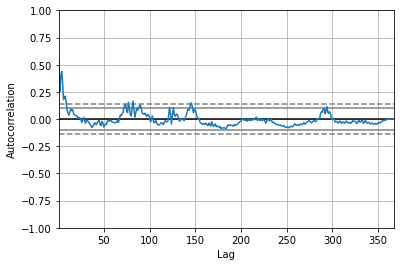

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [70]:
data.reset_index(inplace=True)
data.drop(data.columns[0], axis=1, inplace=True)

# tenure = datetime.datetime.now() - data.ds.min()
# recency = datetime.datetime.now() - data.ds.max()

data_diff = differencing(data['y'])
if 7 not in data_diff.Shift:
    print('No weekly seasonality in ', category_sku[i])
    sku_stationarity.append((i,category_sku[i]))
    print('continue')
   # continue
data['Seasonal First Difference'] = data['y'] - data['y'].shift(7)

print("DickeyFuller test results of ")
print(adfuller_test(data['Seasonal First Difference'].dropna()))

autocorrelation_plot(data['y'])
plt.show()

df0 = pd.DataFrame()
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()

df0, model0, test0, train0 = uni_sarimax(data)
if len(train0)<=7:
    #continue
    print('continue')
df1, model1, test1 = multi_sarimax(data)
df2, model2, test2 = uni_prophet(data)
df3, model3, test3 = multi_prophet(data)
if (len(test0)<=4)|(len(test1)<=4)|(len(test2)<=4)|(len(test3)<=4 | len(train0)<=7):
    #continue
    print('continue')

df0['mape'] = mean_absolute_percentage_error(df0.y, df0.yhat)
df1['mape'] = mean_absolute_percentage_error(df1.y, df1.yhat)
df2['mape'] = mean_absolute_percentage_error(df2.y, df2.yhat)
df3['mape'] = mean_absolute_percentage_error(df3.y, df3.yhat)

df = pd.concat([df0, df1, df2, df3])

min_err_algo = selecting_best_model(df)


if min_err_algo == algorithm[0]:
    data.index = data.ds
    a = sm.tsa.arma_order_select_ic(data['Seasonal First Difference'].dropna(), max_ar=6, max_ma=6, ic='aic', trend='c')
    p= a['aic_min_order'][0]
    q= a['aic_min_order'][1]
    arma.append(a['aic_min_order'])
    model = sm.tsa.statespace.SARIMAX(data['y'],
                                  order= (p,1,q) , seasonal_order= (p,1,q,7),
                              #,mle_regression=True, 
                                  initialization='approximate_diffuse')
    start_params = np.r_[[0] * (model.k_params - 1), 1]
    result = model.fit(start_params=start_params)
    forecast = result.forecast(len(futureData))
    forecast= pd.DataFrame(forecast, columns=['yhat'])
    forecast.reset_index(inplace=True)
    forecast['ds'] = futureData.ds
elif min_err_algo == algorithm[1]:
    data.index = data.ds
    a = sm.tsa.arma_order_select_ic(data['Seasonal First Difference'].dropna(), max_ar=6, max_ma=6, ic='aic', trend='c')
    p= a['aic_min_order'][0]
    q= a['aic_min_order'][1]
    arma.append(a['aic_min_order'])
    model = sm.tsa.statespace.SARIMAX(data['y'],
                                      exog=data[['Inf count','WeekDay', 'Weekend', 'Launch_Event', 'BOGO_Event','Other_Event','Facebook FOLLOWERS COUNT', 'Instagram FOLLOWERS COUNT', 'Twitch FOLLOWERS COUNT', 'Twitter FOLLOWERS COUNT', 'YouTube FOLLOWERS COUNT']].values,
                                  order= (p,1,q) , seasonal_order= (p,1,q,7),
                              #,mle_regression=True, 
                                  initialization='approximate_diffuse')
    start_params = np.r_[[0] * (model.k_params - 1), 1]
    result = model.fit(start_params=start_params)
    forecast = result.forecast(len(futureData),
                       exog=futureData[['Inf count','WeekDay', 'Weekend', 'Launch_Event', 'BOGO_Event','Other_Event','Facebook FOLLOWERS COUNT', 'Instagram FOLLOWERS COUNT', 'Twitch FOLLOWERS COUNT', 'Twitter FOLLOWERS COUNT', 'YouTube FOLLOWERS COUNT']].values)
    forecast= pd.DataFrame(forecast, columns=['yhat'])
    forecast.reset_index(inplace=True)
    forecast['ds'] = futureData.ds
elif min_err_algo == algorithm[2]:
    model = Prophet()
    train = data[['ds','y']]
    model.fit(train)
    X_test = futureData[['ds']]
    forecast = model.predict(X_test)[['ds','yhat']]
else:
    model = Prophet()
    model.add_regressor('Inf count')
    model.add_regressor('WeekDay')
    model.add_regressor('Weekend')
    model.add_regressor('Launch_Event')
    model.add_regressor('BOGO_Event')
    model.add_regressor('Other_Event')
    model.add_regressor('Facebook')
    model.add_regressor('Instagram')
    model.add_regressor('Twitch')
    model.add_regressor('Twitter')
    model.add_regressor('YouTube')

    model.fit(data)

    X_test = futureData[['ds', 'Inf count', 'WeekDay', 'Weekend', 'Launch_Event', 'BOGO_Event', 'Other_Event',
                         'Facebook', 'Instagram', 'Twitch', 'Twitter', 'YouTube']]
    forecast = model.predict(X_test)[['ds','yhat']]

forecast['Launch Date']= data.ds.min()





#   test['forecast_s']=pred
#   test[['Qty','forecast_s']].plot(figsize=(12,8))
forecast.to_excel(r'Predictions\merged-pdp.xlsx', index=False)

DickeyFuller test results of  CB-BM1
ADF Test Statistic : -2.7365887308232275
p-value : 0.06791798470907011
#Lags Used : 12
Number of Observations Used : 59
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
None


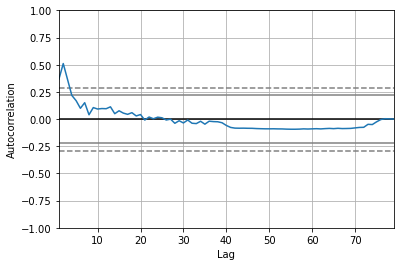

DickeyFuller test results of  CB-SB1
ADF Test Statistic : -5.892476755039402
p-value : 2.9025812282744443e-07
#Lags Used : 13
Number of Observations Used : 120
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
None


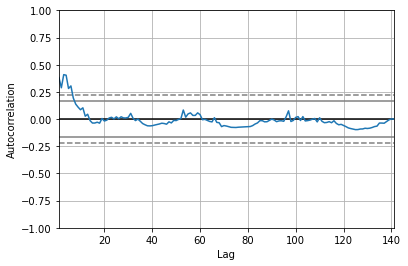

DickeyFuller test results of  CB-PIX1
ADF Test Statistic : -7.916661872563452
p-value : 3.820067262630615e-12
#Lags Used : 6
Number of Observations Used : 149
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
None


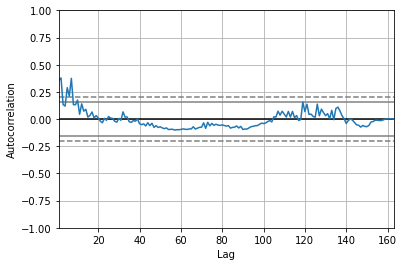

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DickeyFuller test results of  CB-PDP1
ADF Test Statistic : -1.1992958449192332
p-value : 0.6738985482915627
#Lags Used : 11
Number of Observations Used : 61
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
None


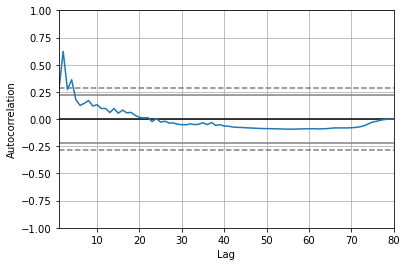

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DickeyFuller test results of  CB-DM1
ADF Test Statistic : -3.0464330912430593
p-value : 0.030779826775346773
#Lags Used : 8
Number of Observations Used : 50
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
None


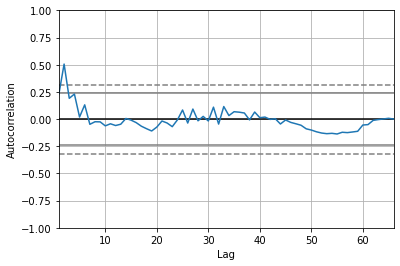

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DickeyFuller test results of  CB-SD1
ADF Test Statistic : -3.5496319127606775
p-value : 0.006800266774413152
#Lags Used : 11
Number of Observations Used : 44
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
None


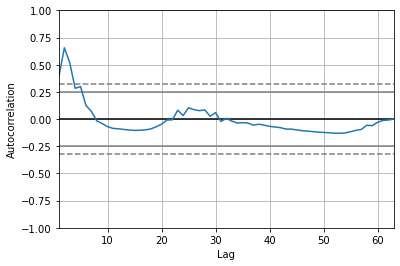

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:

for i in range(n_category_sku):
    data = category_data.loc[category_data.SKU == category_sku[i], ['ds', 'y', 'Inf count', 'WeekDay',
                                                     'Weekend', 'Launch_Event', 'BOGO_Event', 'Other_Event',
                                                                    'Facebook FOLLOWERS COUNT', 'Instagram FOLLOWERS COUNT', 'Twitch FOLLOWERS COUNT', 'Twitter FOLLOWERS COUNT', 'YouTube FOLLOWERS COUNT']]
    data.reset_index(inplace=True)
    data.drop(data.columns[0], axis=1, inplace=True)
    
   # tenure = datetime.datetime.now() - data.ds.min()
   # recency = datetime.datetime.now() - data.ds.max()
    
    if len(data)>=30:
        data_diff = differencing(data['y'])
        if 7 not in data_diff.Shift:
            print('No weekly seasonality in ', category_sku[i])
            sku_stationarity.append((i,category_sku[i]))
            continue
        data['Seasonal First Difference'] = data['y'] - data['y'].shift(7)

        print("DickeyFuller test results of ",category_sku[i])
        print(adfuller_test(data['Seasonal First Difference'].dropna()))

        autocorrelation_plot(data['y'])
        plt.show()

        df0 = pd.DataFrame()
        df1 = pd.DataFrame()
        df2 = pd.DataFrame()
        df3 = pd.DataFrame()

        df0, model0, test0, train0 = uni_sarimax(data)
        if len(train0)<=7:
            continue
        df1, model1, test1 = multi_sarimax(data)
        df2, model2, test2 = uni_prophet(data)
        df3, model3, test3 = multi_prophet(data)
        if (len(test0)<=4)|(len(test1)<=4)|(len(test2)<=4)|(len(test3)<=4 | len(train0)<=7):
            continue

        df0['mape'] = mean_absolute_percentage_error(df0.y, df0.yhat)
        df1['mape'] = mean_absolute_percentage_error(df1.y, df1.yhat)
        df2['mape'] = mean_absolute_percentage_error(df2.y, df2.yhat)
        df3['mape'] = mean_absolute_percentage_error(df3.y, df3.yhat)

        df = pd.concat([df0, df1, df2, df3])

        min_err_algo = selecting_best_model(df)


        if min_err_algo == algorithm[0]:
            data.index = data.ds
            a = sm.tsa.arma_order_select_ic(data['Seasonal First Difference'].dropna(), max_ar=6, max_ma=6, ic='aic', trend='c')
            p= a['aic_min_order'][0]
            q= a['aic_min_order'][1]
            arma.append(a['aic_min_order'])
            model = sm.tsa.statespace.SARIMAX(data['y'],
                                          order= (p,1,q) , seasonal_order= (p,1,q,7),
                                      #,mle_regression=True, 
                                          initialization='approximate_diffuse')
            start_params = np.r_[[0] * (model.k_params - 1), 1]
            result = model.fit(start_params=start_params)
            forecast = result.forecast(len(futureData))
            forecast= pd.DataFrame(forecast, columns=['yhat'])
            forecast.reset_index(inplace=True)
            forecast['ds'] = futureData.ds
        elif min_err_algo == algorithm[1]:
            data.index = data.ds
            a = sm.tsa.arma_order_select_ic(data['Seasonal First Difference'].dropna(), max_ar=6, max_ma=6, ic='aic', trend='c')
            p= a['aic_min_order'][0]
            q= a['aic_min_order'][1]
            arma.append(a['aic_min_order'])
            model = sm.tsa.statespace.SARIMAX(data['y'],
                                              exog=data[['Inf count','WeekDay', 'Weekend', 'Launch_Event', 'BOGO_Event','Other_Event','Facebook FOLLOWERS COUNT', 'Instagram FOLLOWERS COUNT', 'Twitch FOLLOWERS COUNT', 'Twitter FOLLOWERS COUNT', 'YouTube FOLLOWERS COUNT']].values,
                                          order= (p,1,q) , seasonal_order= (p,1,q,7),
                                      #,mle_regression=True, 
                                          initialization='approximate_diffuse')
            start_params = np.r_[[0] * (model.k_params - 1), 1]
            result = model.fit(start_params=start_params)
            forecast = result.forecast(len(futureData),
                               exog=futureData[['Inf count','WeekDay', 'Weekend', 'Launch_Event', 'BOGO_Event','Other_Event','Facebook FOLLOWERS COUNT', 'Instagram FOLLOWERS COUNT', 'Twitch FOLLOWERS COUNT', 'Twitter FOLLOWERS COUNT', 'YouTube FOLLOWERS COUNT']].values)
            forecast= pd.DataFrame(forecast, columns=['yhat'])
            forecast.reset_index(inplace=True)
            forecast['ds'] = futureData.ds
        elif min_err_algo == algorithm[2]:
            model = Prophet()
            train = data[['ds','y']]
            model.fit(train)
            X_test = futureData[['ds']]
            forecast = model.predict(X_test)[['ds','yhat']]
        else:
            model = Prophet()
            model.add_regressor('Inf count')
            model.add_regressor('WeekDay')
            model.add_regressor('Weekend')
            model.add_regressor('Launch_Event')
            model.add_regressor('BOGO_Event')
            model.add_regressor('Other_Event')
            model.add_regressor('Facebook FOLLOWERS COUNT')
            model.add_regressor('Instagram FOLLOWERS COUNT')
            model.add_regressor('Twitch FOLLOWERS COUNT')
            model.add_regressor('Twitter FOLLOWERS COUNT')
            model.add_regressor('YouTube FOLLOWERS COUNT')

            model.fit(data)

            X_test = futureData[['ds', 'Inf count', 'WeekDay', 'Weekend', 'Launch_Event', 'BOGO_Event', 'Other_Event',
                                 'Facebook FOLLOWERS COUNT', 'Instagram FOLLOWERS COUNT', 'Twitch FOLLOWERS COUNT', 'Twitter FOLLOWERS COUNT', 'YouTube FOLLOWERS COUNT']]
            forecast = model.predict(X_test)[['ds','yhat']]
            
        forecast['Launch Date']= data.ds.min()





     #   test['forecast_s']=pred
     #   test[['Qty','forecast_s']].plot(figsize=(12,8))
        forecast.to_excel(r'Predictions\predicted '+str(category_sku[i])+'.xlsx', index=False)
        #del test
        #del train
        del data

      #  continue
        

In [25]:
i

7

In [26]:
data

NameError: name 'data' is not defined